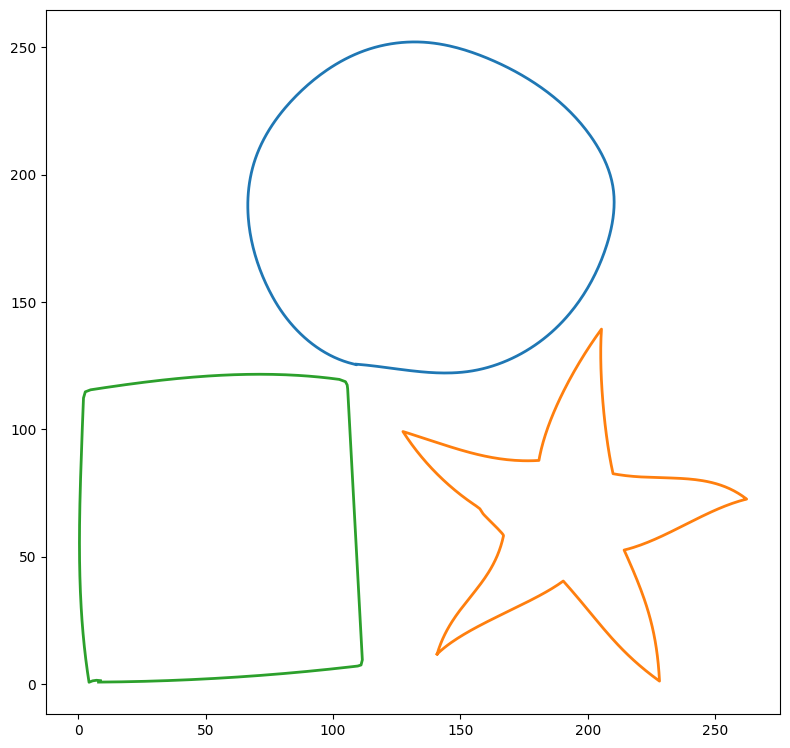

In [18]:
import numpy as np
import matplotlib.pyplot as plt


def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=",")
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs


def plot(paths_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(paths_XYs):
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], linewidth=2)
    ax.set_aspect("equal")
    plt.show()


# Example usage
csv_path = "./isolated.csv"  # Update with the correct path to your CSV file
paths_XYs = read_csv(csv_path)
plot(paths_XYs)

# Detecting Circle

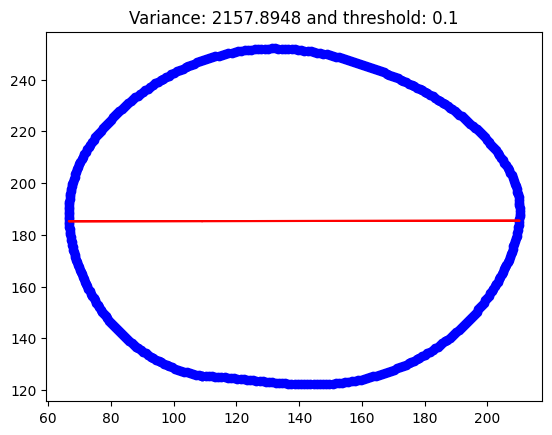

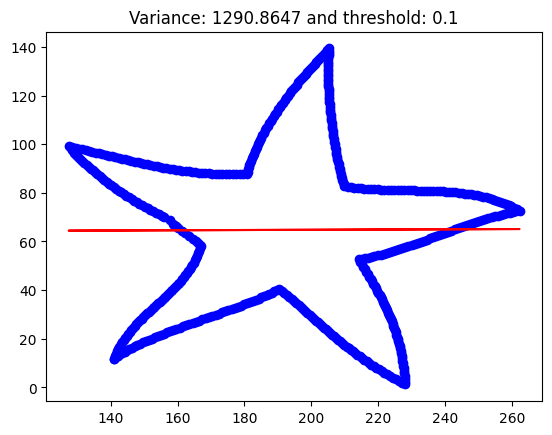

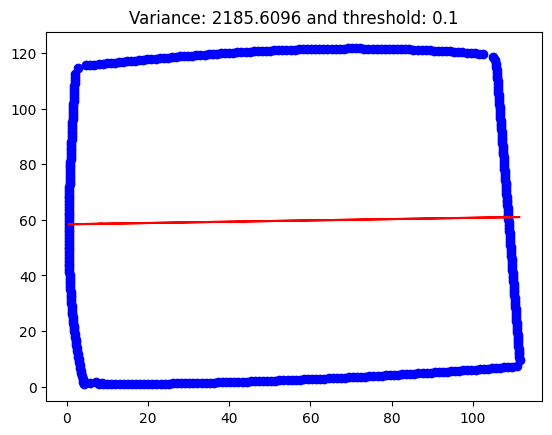

In [19]:
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

def is_straight_line(XY, threshold=1e-1, plot=False):
    X = XY[:, 0].reshape(-1, 1)
    y = XY[:, 1]

    model = LinearRegression()
    model.fit(X, y)

    y_pred = model.predict(X)
    residuals = y - y_pred
    variance = np.var(residuals)

    if plot:
        plt.scatter(X, y, color='blue')
        plt.plot(X, y_pred, color='red')
        plt.title(f"Variance: {variance:.4f} and threshold: {threshold}")
        plt.show()

    return variance < threshold, model


# Example usage
for path in paths_XYs:
    for XY in path:
        is_line, model = is_straight_line(XY, plot=True)
        if is_line:
            print("Detected a straight line with slope:", model.coef_[0])

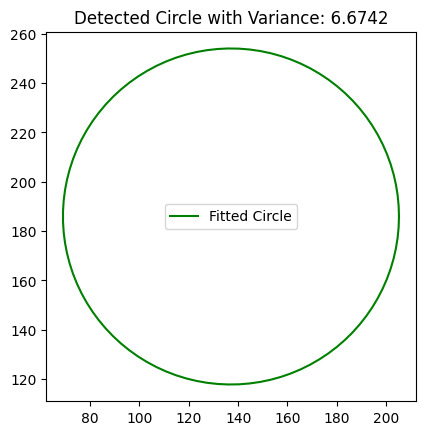

Detected a circle with center: (np.float64(137.08856515322157), np.float64(185.92876461692873)) and radius: 68.13670280401563


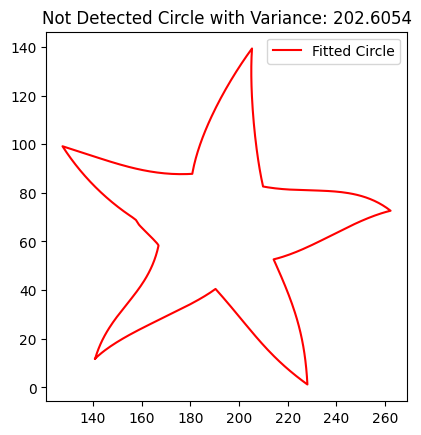

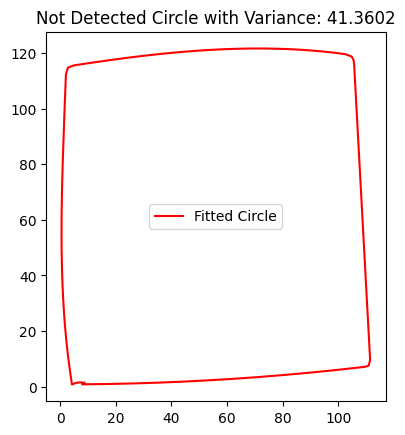

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from sklearn.linear_model import RANSACRegressor

def fit_circle_ransac(XY, plot=False, threshold = 10):
    x_m = np.mean(XY[:, 0])
    y_m = np.mean(XY[:, 1])
    
    def calc_R(xc, yc):
        return np.sqrt((XY[:, 0] - xc)**2 + (XY[:, 1] - yc)**2)
    
    def f(c):
        Ri = calc_R(*c)
        return Ri - Ri.mean()

    # Initial circle fitting using least squares
    center_estimate = x_m, y_m
    result = least_squares(f, center_estimate)
    xc, yc = result.x
    Ri = calc_R(xc, yc)
    R = Ri.mean()
    residuals = Ri - R
    
    # Use RANSAC to improve robustness against outliers
    ransac = RANSACRegressor(residual_threshold=np.percentile(np.abs(residuals), 50))
    X_ransac = XY[:, 0].reshape(-1, 1)
    y_ransac = XY[:, 1]
    ransac.fit(X_ransac, y_ransac)
    
    inlier_mask = ransac.inlier_mask_
    XY_inliers = XY[inlier_mask]
    
    # Refit the circle with inliers
    x_m_inliers = np.mean(XY_inliers[:, 0])
    y_m_inliers = np.mean(XY_inliers[:, 1])
    center_estimate = x_m_inliers, y_m_inliers
    result = least_squares(f, center_estimate)
    xc, yc = result.x
    Ri = calc_R(xc, yc)
    R = Ri.mean()
    residuals = Ri - R
    variance = np.var(residuals)

    if plot:
        theta = np.linspace(0, 2 * np.pi, 100)
        circle_x = xc + R * np.cos(theta)
        circle_y = yc + R * np.sin(theta)
        
        plt.figure()
        if(variance<=threshold):
            plt.plot(circle_x, circle_y, 'green', label='Fitted Circle')
            # plt.scatter(XY[:, 0], XY[:, 1], label='Data Points')
            # plt.scatter([xc], [yc], color='blue', label='Center')
            plt.legend()
            plt.gca().set_aspect('equal', adjustable='box')
            plt.title(f"Detected Circle with Variance: {variance:.4f}")
            plt.show()
        else:
            plt.plot(X_ransac, y_ransac, 'red', label='Fitted Circle')
            # plt.scatter(XY[:, 0], XY[:, 1], label='Data Points')
            # plt.scatter([xc], [yc], color='blue', label='Center')
            plt.legend()
            plt.gca().set_aspect('equal', adjustable='box')
            plt.title(f"Not Detected Circle with Variance: {variance:.4f}")
            plt.show()

    return (xc, yc), R, variance

def is_circle(XY, threshold=10, plot=False):
    center, radius, variance = fit_circle_ransac(XY, plot=plot, threshold = threshold)
    return variance < threshold, center, radius

# Example usage with plotting
for path in paths_XYs:
    for XY in path:
        is_circ, center, radius = is_circle(XY, plot=True)
        if is_circ:
            print(f"Detected a circle with center: {center} and radius: {radius}")


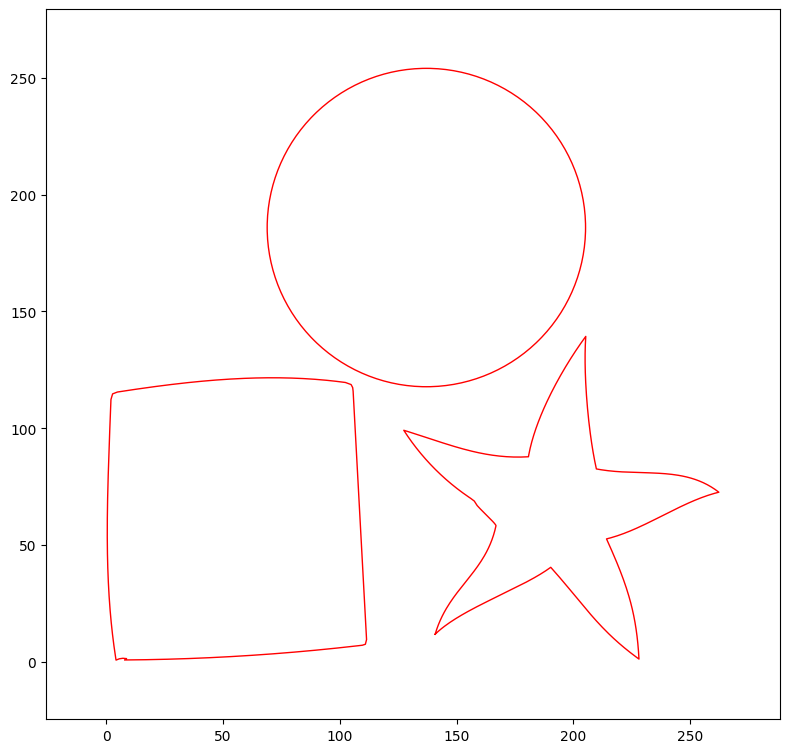

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def plot_detected_shapes(paths_XYs, detected_shapes, buffer=0.1):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))

    # Initialize limits
    x_min, x_max = np.inf, -np.inf
    y_min, y_max = np.inf, -np.inf

    for shape in detected_shapes:
        if shape['type'] == 'line':
            model = shape['model']
            x_vals = np.array(ax.get_xlim())
            y_vals = model.coef_[0] * x_vals + model.intercept_
            ax.plot(x_vals, y_vals, '--', color='red')
        elif shape['type'] == 'circle':
            center, radius = shape['center'], shape['radius']
            x_min = min(x_min, center[0] - radius)
            x_max = max(x_max, center[0] + radius)
            y_min = min(y_min, center[1] - radius)
            y_max = max(y_max, center[1] + radius)
            circle = plt.Circle(center, radius, color='red', fill=False, linestyle='-')
            ax.add_artist(circle)
        else:
            ax.plot(shape['xy'][:, 0], shape['xy'][:, 1], linewidth=1, color='red')
            # Update limits based on other shapes
            x_min = min(x_min, np.min(shape['xy'][:, 0]))
            x_max = max(x_max, np.max(shape['xy'][:, 0]))
            y_min = min(y_min, np.min(shape['xy'][:, 1]))
            y_max = max(y_max, np.max(shape['xy'][:, 1]))

    # Apply buffer to limits
    x_range = x_max - x_min
    y_range = y_max - y_min
    x_buffer = x_range * buffer
    y_buffer = y_range * buffer

    ax.set_xlim(x_min - x_buffer, x_max + x_buffer)
    ax.set_ylim(y_min - y_buffer, y_max + y_buffer)
    
    ax.set_aspect('equal')
    plt.show()

# Example usage
detected_shapes = []
for path in paths_XYs:
    for XY in path:
        is_line, model = is_straight_line(XY)
        if is_line:
            detected_shapes.append({'type': 'line', 'model': model})

        is_circ, center, radius = is_circle(XY)
        if is_circ:
            detected_shapes.append({'type': 'circle', 'center': center, 'radius': radius})
        else:
            detected_shapes.append({'type': 'other', 'xy': XY})

plot_detected_shapes(paths_XYs, detected_shapes)


# Detecting Rectangle

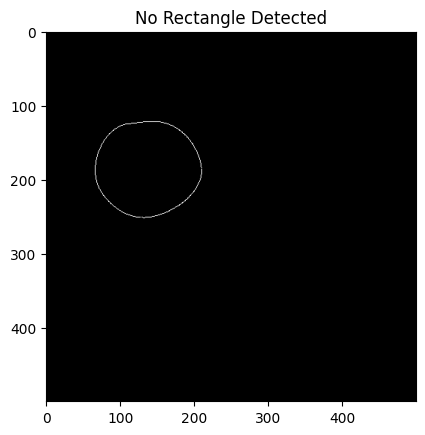

Detected rectangle with vertices: None


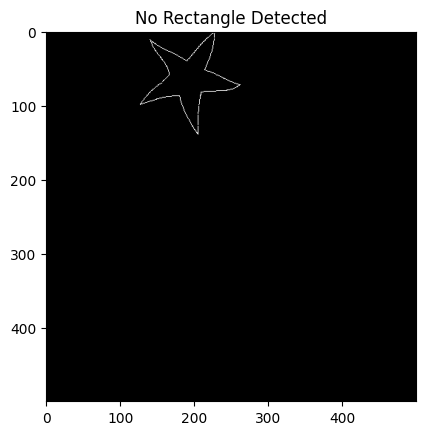

Detected rectangle with vertices: None


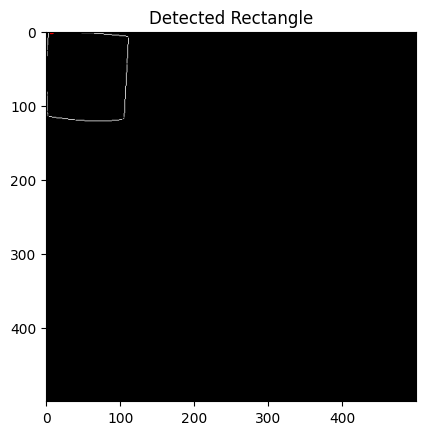

Detected rectangle with vertices: [[[7 1]]

 [[8 1]]

 [[9 0]]

 [[7 0]]]


In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def fit_rectangle(XY, plot=False):
    img = np.zeros((500, 500), dtype=np.uint8)
    for x, y in XY:
        img[int(y), int(x)] = 255
    
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rectangle = None
    for contour in contours:
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:
            rectangle = approx
            break
    
    if plot:
        plt.imshow(img, cmap='gray')
        if rectangle is not None:
            plt.plot(*zip(*rectangle.squeeze()), 'r-', linewidth=2)
            plt.title("Detected Rectangle")
        else:
            plt.title("No Rectangle Detected")
        plt.show()

    return rectangle

# Example usage
for path in paths_XYs:
    for XY in path:
        rectangle = fit_rectangle(XY, plot=True)
        print(f"Detected rectangle with vertices: {rectangle}")


# Detecting Rounded Rectangle

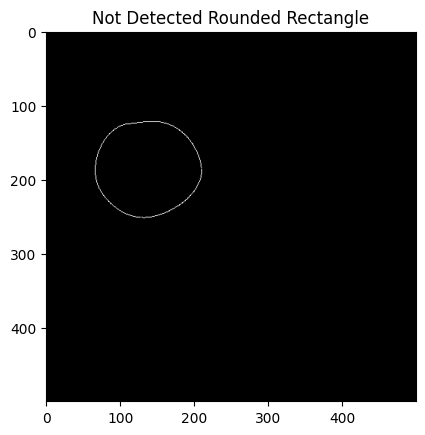

Detected rounded rectangle with vertices: None


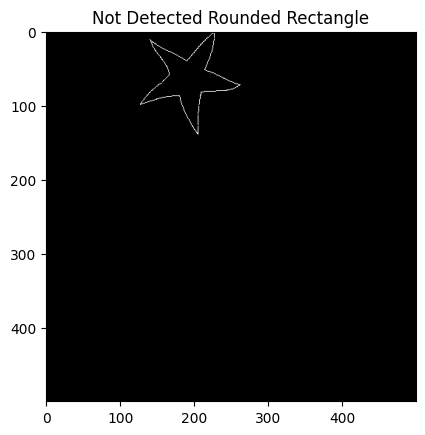

Detected rounded rectangle with vertices: None


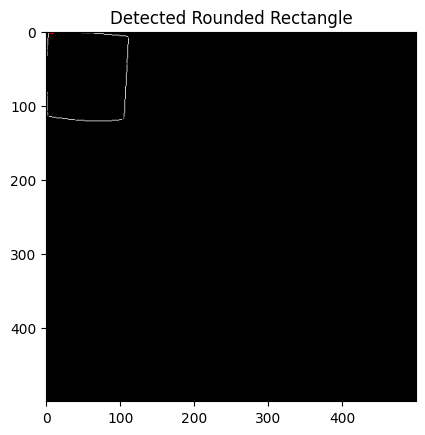

Detected rounded rectangle with vertices: [[[7 1]]

 [[8 1]]

 [[9 0]]

 [[7 0]]]


In [23]:
def fit_rounded_rectangle(XY, plot=False):
    rectangle = fit_rectangle(XY, plot=False)
    img = np.zeros((500, 500), dtype=np.uint8)
    for x, y in XY:
        img[int(y), int(x)] = 255
    
    # Check for rounded corners (this would require further implementation)
    
    if plot:
        plt.imshow(img, cmap='gray')
        if rectangle is not None:
            plt.plot(*zip(*rectangle.squeeze()), 'r-', linewidth=2)
            plt.gca().set_aspect('equal', adjustable='box')
            plt.title("Detected Rounded Rectangle")
        else:
            plt.title("Not Detected Rounded Rectangle")
        plt.show()

    return rectangle

# Example usage
for path in paths_XYs:
    for XY in path:
        rounded_rectangle = fit_rounded_rectangle(XY, plot=True)
        print(f"Detected rounded rectangle with vertices: {rounded_rectangle}")


# Detecting Polygon 

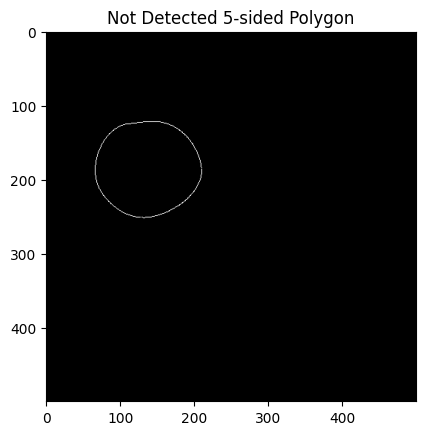

Detected polygon with vertices: None


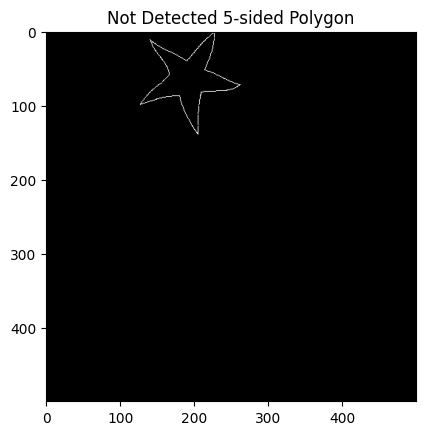

Detected polygon with vertices: None


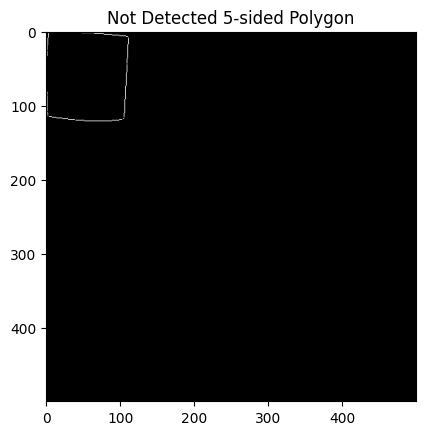

Detected polygon with vertices: None


In [12]:
def fit_polygon(XY, sides, plot=False):
    img = np.zeros((500, 500), dtype=np.uint8)
    for x, y in XY:
        img[int(y), int(x)] = 255
    
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    polygon = None
    for contour in contours:
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == sides:
            polygon = approx
            break
    
    if plot:
        plt.imshow(img, cmap='gray')
        if polygon is not None:
            plt.plot(*zip(*polygon.squeeze()), 'r-', linewidth=2)
            plt.gca().set_aspect('equal', adjustable='box')
            plt.title(f"Detected {sides}-sided Polygon")
        else:
            plt.title(f"Not Detected {sides}-sided Polygon")
        plt.show()

    return polygon

# Example usage
for path in paths_XYs:
    for XY in path:
        polygon = fit_polygon(XY, sides=5, plot=True)  # Example for a pentagon
        print(f"Detected polygon with vertices: {polygon}")


# Detecting Star

0
397
False
0
6
True
0
323
False


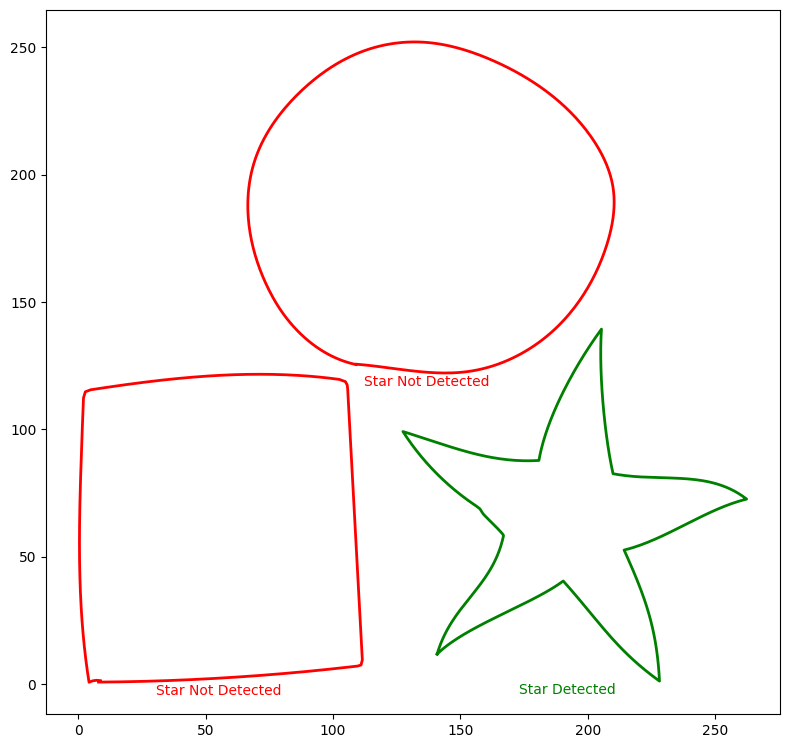

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull


def fit_star(XY, plot=False, tolerance=10):
    hull = ConvexHull(XY)
    hull_points = XY[hull.vertices]

    # Calculate distances between consecutive hull points
    distances = np.linalg.norm(np.diff(hull_points, axis=0, append=hull_points[:1]), axis=1)

    # Check if distances alternate between long and short
    long_distances = distances[::2]
    short_distances = distances[1::2] if len(distances) % 2 == 0 else distances[1::2][:-1]

    long_distances_mean = np.mean(long_distances)
    short_distances_mean = np.mean(short_distances)

    alternating = np.all(np.abs(long_distances - long_distances_mean) < tolerance * long_distances_mean) and \
                  np.all(np.abs(short_distances - short_distances_mean) < tolerance * short_distances_mean)

    # Additional check: Angle between points (star points should form sharper angles)
    angles = []
    for i in range(len(hull_points)):
        p1 = hull_points[i - 1]
        p2 = hull_points[i]
        p3 = hull_points[(i + 1) % len(hull_points)]

        v1 = p1 - p2
        v2 = p3 - p2

        angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
        angles.append(np.degrees(angle))

    sharp_angles = np.array(angles) < 90
    print(np.sum(sharp_angles))
    print(len(hull_points))
    print(alternating)
    star = alternating or np.sum(sharp_angles) > len(hull_points) // 2

    if plot:
        plt.figure()
        plt.plot(XY[:, 0], XY[:, 1], 'o', label='Data Points')
        if star:
            plt.plot(hull_points[:, 0], hull_points[:, 1], 'green', lw=2, label='Detected Star')
            plt.title("Detecting star")
        else:
            plt.plot(hull_points[:, 0], hull_points[:, 1], 'red', lw=2, label='Convex Hull (Not a Star)')
            plt.title("Not Detecting star")
        plt.gca().set_aspect('equal', adjustable='box')
        plt.legend()
        plt.title("Detected Star" if star else "Not a Star")
        plt.show()

    return star


def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=",")
    paths_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        paths_XYs.append(XYs)
    return paths_XYs


def plot(paths_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(paths_XYs):
        for XY in XYs:
            star = fit_star(XY, plot=False)
            color = 'green' if star else 'red'
            ax.plot(XY[:, 0], XY[:, 1], color=color, linewidth=2)
            center_x = np.mean(XY[:, 0])
            center_y = np.min(XY[:, 1]) - 5  # Adjust the position as needed
            ax.text(center_x, center_y, 'Star Detected' if star else 'Star Not Detected', 
                    horizontalalignment='center', color=color)
            # if star:
            #     print(f"Shape {i + 1}, points {XY}: Detected Star")
            # else:
            #     print(f"Shape {i + 1}, points {XY}: Not a Star")
    ax.set_aspect("equal")
    plt.show()

# Example usage
csv_path = "./isolated.csv"  # Update with the correct path to your CSV file
paths_XYs = read_csv(csv_path)
plot(paths_XYs)


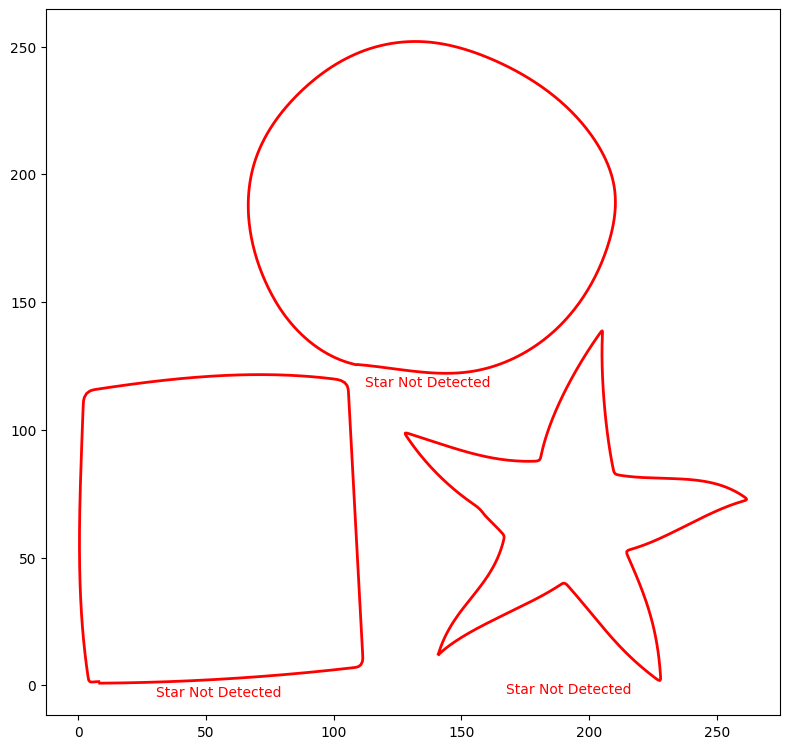

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy.ndimage import gaussian_filter1d

def fit_star(XY, plot=False, tolerance=0.3, angle_tolerance=25):
    # Apply smoothing to handle hand-drawn inaccuracies
    XY[:, 0] = gaussian_filter1d(XY[:, 0], sigma=1)
    XY[:, 1] = gaussian_filter1d(XY[:, 1], sigma=1)

    hull = ConvexHull(XY)
    hull_points = XY[hull.vertices]
    
    if len(hull_points) < 5:
        return False, None  # Early exit if the hull doesn't have enough vertices

    # Calculate distances between consecutive hull points
    distances = np.linalg.norm(np.diff(hull_points, axis=0, append=hull_points[:1]), axis=1)

    # Handle cases where the number of distances is not alternating correctly
    if len(distances) % 2 == 0:
        long_distances = distances[::2]
        short_distances = distances[1::2]
    else:
        # Shift indices to try and get a better separation
        long_distances = distances[::2]
        short_distances = distances[1::2]
        if len(long_distances) > len(short_distances):
            long_distances = long_distances[:-1]  # Trim the last element to match lengths

    # Check if the distance ratio is within tolerance
    ratio = long_distances / short_distances
    if not np.all((1 - tolerance) < ratio) or not np.all(ratio < (1 + tolerance)):
        return False, None  # Early exit if distances don't follow a star-like pattern

    # Verify angles between points
    angles = []
    for i in range(len(hull_points)):
        p1 = hull_points[i - 1]
        p2 = hull_points[i]
        p3 = hull_points[(i + 1) % len(hull_points)]

        v1 = p1 - p2
        v2 = p3 - p2

        angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
        angles.append(np.degrees(angle))

    # Allow for a range of angles to account for hand-drawn variability
    sharp_angles = np.array(angles) < (90 + angle_tolerance)
    star = np.sum(sharp_angles) >= 5

    if plot:
        plt.figure()
        plt.plot(XY[:, 0], XY[:, 1], 'o', label='Data Points')
        if star:
            plt.plot(hull_points[:, 0], hull_points[:, 1], 'green', lw=2, label='Detected Star')
            plt.title("Detecting star")
        else:
            plt.plot(hull_points[:, 0], hull_points[:, 1], 'red', lw=2, label='Convex Hull (Not a Star)')
            plt.title("Not Detecting star")
        plt.gca().set_aspect('equal', adjustable='box')
        plt.legend()
        plt.title("Detected Star" if star else "Not a Star")
        plt.show()

    return star, hull_points if star else None


def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=",")
    paths_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        paths_XYs.append(XYs)
    return paths_XYs


def redraw_star(hull_points, ax):
    # Draw star by connecting vertices in the correct order
    for i in range(len(hull_points)):
        ax.plot([hull_points[i, 0], hull_points[(i + 2) % len(hull_points), 0]],
                [hull_points[i, 1], hull_points[(i + 2) % len(hull_points), 1]],
                'g-', linewidth=2)


def plot(paths_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(paths_XYs):
        for XY in XYs:
            star, hull_points = fit_star(XY, plot=False)
            color = 'green' if star else 'red'
            ax.plot(XY[:, 0], XY[:, 1], color=color, linewidth=2)
            if star:
                redraw_star(hull_points, ax)
            center_x = np.mean(XY[:, 0])
            center_y = np.min(XY[:, 1]) - 5  # Adjust the position as needed
            ax.text(center_x, center_y, 'Star Detected' if star else 'Star Not Detected', 
                    horizontalalignment='center', color=color)
    ax.set_aspect("equal")
    plt.show()

# Example usage
csv_path = "./isolated.csv"  # Update with the correct path to your CSV file
paths_XYs = read_csv(csv_path)
plot(paths_XYs)


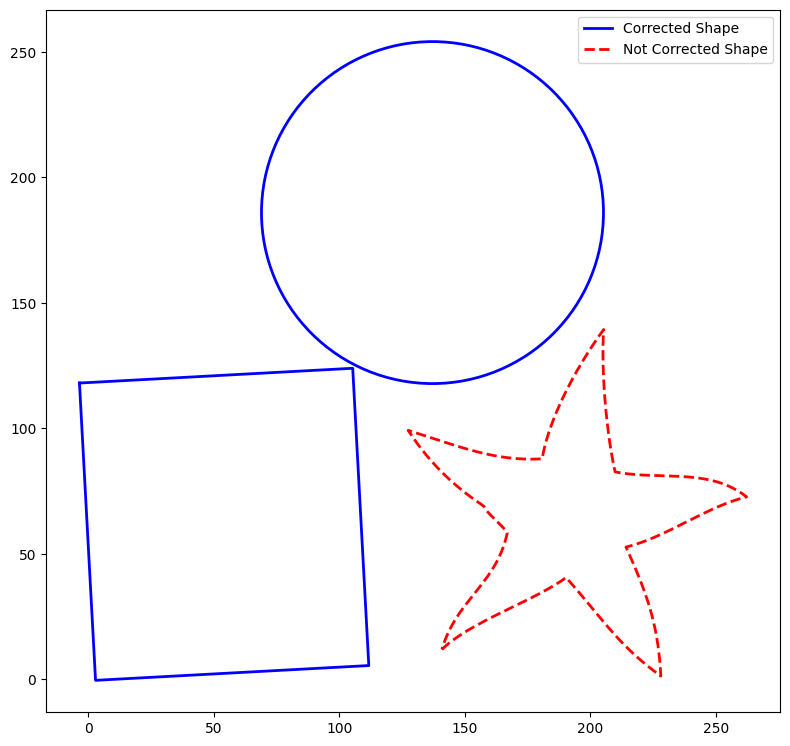

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import leastsq
from scipy.spatial import distance
from sklearn.cluster import DBSCAN
import cv2

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=",")
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def cluster_shapes(XY, eps=10, min_samples=5):
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(XY)
    labels = clustering.labels_
    clusters = [XY[labels == i] for i in range(max(labels) + 1)]
    return clusters

def detect_circle(XY):
    def calc_R(xc, yc):
        return np.sqrt((XY[:, 0] - xc)**2 + (XY[:, 1] - yc)**2)

    def f_2(c):
        Ri = calc_R(*c)
        return Ri - Ri.mean()

    center_estimate = np.mean(XY, axis=0)
    center, _ = leastsq(f_2, center_estimate)
    radius = calc_R(*center).mean()
    return center, radius

def detect_rectangle(XY):
    XY = XY.astype(np.float32)
    rect = cv2.minAreaRect(XY)
    box = cv2.boxPoints(rect)
    return box

def detect_shape(XY):
    if len(XY) < 5:
        return None

    center, radius = detect_circle(XY)
    error = np.sqrt(np.sum((np.sqrt((XY[:, 0] - center[0])**2 + (XY[:, 1] - center[1])**2) - radius)**2))
    
    if error < 1 * radius:  # Tolerance for circular shape
        return 'circle', center, radius

    rect = detect_rectangle(XY)
    rect_area = cv2.contourArea(rect.astype(np.float32))
    hull = cv2.convexHull(XY.astype(np.float32))
    hull_area = cv2.contourArea(hull)
    if np.abs(rect_area - hull_area) < 0.1 * hull_area:  # Tolerance for rectangle
        return 'rectangle', rect

    return 'other', XY

def redraw_shape(shape_info, ax):
    if shape_info[0] == 'circle':
        center, radius = shape_info[1], shape_info[2]
        circle = plt.Circle(center, radius, color='b', fill=False, linewidth=2, label='Corrected Shape')
        ax.add_patch(circle)
    elif shape_info[0] == 'rectangle':
        rect = shape_info[1]
        ax.plot(*np.append(rect, [rect[0]], axis=0).T, 'b-', linewidth=2, label='Corrected Shape')
    elif shape_info[0] == 'other':
        XY = shape_info[1]
        ax.plot(XY[:, 0], XY[:, 1], 'r--', linewidth=2, label='Not Corrected Shape')

def plot(paths_XYs, eps=10, min_samples=5):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    for i, XYs in enumerate(paths_XYs):
        for XY in XYs:
            clusters = cluster_shapes(XY, eps=eps, min_samples=min_samples)
            for cluster in clusters:
                shape_info = detect_shape(cluster)
                if shape_info:
                    redraw_shape(shape_info, ax)
    ax.set_aspect("equal")
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    plt.show()

# Example usage
csv_path = "./isolated.csv"  # Update with the correct path to your CSV file
paths_XYs = read_csv(csv_path)
plot(paths_XYs)